In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
from tensorflow.keras import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#path = '/content/drive/My Drive/'
#os.listdir(path) 


Mounted at /content/drive


In [3]:
###  Some global parameters daclaration :


#IMAGE_SIZE = (256, 256)  # (500, 500) # (300, 300)
#location_of_weights = path +'vgg19_weights.h5'
#location = '/content/drive/My Drive/style_transfer_images/'


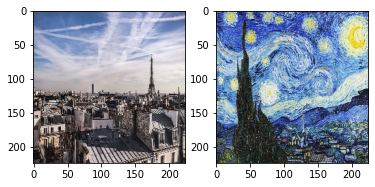

In [4]:
%matplotlib inline

contain_image = cv2.imread('/content/drive/My Drive/style_transfer_images/sample_1.jpeg')
contain_image = cv2.resize(contain_image, (224,224))#, interpolation=cv2.INTER_AREA)
#contain_image = contain_image.reshape(224,224,3) # return the image with shaping that TF wants.
#np.squeeze(contain_image)


image = cv2.cvtColor(contain_image, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(image)

style_image = cv2.imread('/content/drive/My Drive/style_transfer_images/neural_1.jpeg')
style_image = cv2.resize(style_image, (224,224))#, interpolation=cv2.INTER_AREA)
#style_image = style_image.reshape(224,224,3) # return the image with shaping that TF wants.
#np.squeeze(style_image)

image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,2)
plt.imshow(image)
plt.show()

contain_image = tf.image.convert_image_dtype(contain_image, tf.float32)
style_image = tf.image.convert_image_dtype(style_image, tf.float32)

# plot_image('contain.jpg', [1,2,1])
# plot_image('style.jpg', [1,2,2])

In [5]:
# def load_image(image_name):
#   # image loading, resizing and convrsion to float32.

#   img_location = location + image_name
#   image = cv2.imread(img_location)
#   image = cv2.resize(image, (256,256))
#   image = tf.image.convert_image_dtype(image, tf.float32)

#   return image

# def plot_image(image_name, a1, a2, a3):

#   #%matplotlib inline

#   img_location = location + image_name
#   image = cv2.imread(img_location)
#   image = cv2.resize(image, (256,256))
#   #image = tf.image.convert_image_dtype(image, tf.float32)

#   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   plt.subplot(a1, a2, a3)
#   plt.imshow(image)
#   plt.show()
  

In [6]:
def Gram_function(input_tensor):   # implementimg gram function using tensorflow library of linear algebra named einsum

    alg_output = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    shape = tf.shape(input_tensor)
    matrix = tf.expand_dims(alg_output, axis = 0)  # adds a 1 in the first column of shape tuple.
    i_j = tf.cast(shape[1]*shape[2], tf.float32)
    gram_result = matrix/i_j

    return gram_result

In [7]:
def VGG():

    vgg = tf.keras.applications.VGG19(include_top=True, weights=None)
    vgg.load_weights('/content/drive/My Drive/vgg19_weights.h5')
    #vgg.summary()

    # content = block4_conv2
    # style = block1_conv1, block2_conv1, block3_conv1, block4_conv1, block5_conv1 

    return vgg

In [8]:
def Custom_Model():
    vgg19 = VGG()
    vgg19.trainable = False
    content_layers = ['block4_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

    content_output = vgg19.get_layer(content_layers[0]).output
    style_output = [vgg19.get_layer(layer).output for layer in style_layers]

    # getting the gram output of the style_output

    gram_style_output = [Gram_function(style) for style in style_output]

    model = Model([vgg19.input], [content_output, gram_style_output])   # args of Model = inputs, outputs and name of model..

    return model



In [9]:
# def Content_loss(content_target, content_output): 

#       content_loss = tf.reduce_mean((content_output - content_target)**2)

#       return content_loss

# def Style_loss(style_target, style_output):

#       style_loss = tf.add_n(([tf.reduce_mean((output_ - target_)**2) for output_, target_ in zip(style_output, style_target)]))

#       return style_loss

def Total_loss(content_target, content_output, style_target, style_output):

    SLW = 1     # style learning weights
    CLW = 1e-4     # container learning weights

    content_loss = tf.reduce_mean((content_output - content_target)**2)
    style_loss = tf.add_n([tf.reduce_mean((output_ - target_)**2) for output_, target_ in zip(style_output, style_target)])
    total_loss = SLW*style_loss + CLW*content_loss
    return total_loss


In [10]:
VGG = Custom_Model()
optimizer = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

target_style = VGG(np.array([style_image*255]))[0]
target_contain  = VGG(np.array([contain_image*255]))[1]

def optimisation(image, epoch):
    with tf.GradientTape() as tape:
        output = VGG(image*255)
        loss = Total_loss(target_contain, output[0], target_style, output[1])
    gradient = tape(loss, image)   # this tries to optimise the loss the function and updates the image on basis of that.
    optimizer.apply_gradients([(gradient, image)])
    image.assign(tf.clip_by_value(image, clip_value_max=1.00, clip_value_min=0.00))   # clipping, because pixels value may overshoot the 255 (max_value)

    if epoch % 10 == 0:
      print(f"Loss after {epoch} = {loss}")


In [11]:
image = tf.image.convert_image_dtype(contain_image, tf.float32)
image = tf.Variable([image])
EPOCHS = 100

for epoch in range(EPOCHS):
    optimisation(image, epoch)

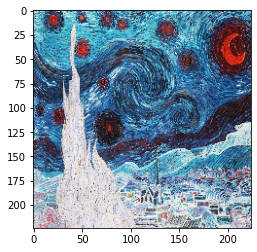

In [12]:
tensor = image*255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor) > 3:
    assert np.shape(tensor)[0] == 1
    tensor = tensor[0]
tensor = PIL.Image.fromarray(tensor)
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
# import numpy as np

# a = np.array([[1,2,3],
#              [2,5,6]])
              
# print(a[0,:])
# print(a[:,1])
# print(a[0,1])

In [14]:
vgg = tf.keras.applications.VGG19(include_top=True, weights=None)
    
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     